# Weekly Revenue Forecasting: LightGBM vs Lasso

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('feature_data/weekly_features.csv')
df.dtypes

week_start_date                    object
coffee_name                        object
weekly_revenue                    float64
weekly_transactions                 int64
avg_transaction_value             float64
transaction_value_volatility      float64
month_first                         int64
week_of_year_first                  int64
hour_of_day_mean                  float64
hour_of_day_std                   float64
hour_of_day_min                     int64
hour_of_day_max                     int64
dominant_day_of_week                int64
weekend_sales_proportion          float64
dominant_time_of_day               object
dominant_weekday                   object
year_week                          object
coffee_encoded                      int64
prev_week_revenue                 float64
prev_week_transactions            float64
prev_2week_revenue                float64
prev_3week_revenue                float64
prev_2week_transactions           float64
prev_3week_transactions           

### Data Prep for LightGBM training for Weekly Revenue prediction by Coffee Name

In [3]:
weekly_features = df.copy()

training_features = [
    # Coffee identifier
    'coffee_encoded',
    
    # lag features
    'prev_week_revenue', 'prev_week_transactions',
    'prev_2week_revenue', 'prev_3week_revenue', 
    'prev_2week_transactions', 'prev_3week_transactions',
    
    # Temporal features
    'month_first', 'week_of_year_first', 'dominant_day_of_week',
    'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
    
    # Sales pattern features
    'weekend_sales_proportion', 'hour_of_day_mean', 'hour_of_day_std',
    'hour_of_day_min', 'hour_of_day_max',
    
    # rolling features
    'revenue_4w_mean', 'revenue_4w_std', 'transactions_4w_mean',
    'revenue_8w_mean', 'revenue_12w_mean',
    'transactions_8w_mean', 'transactions_12w_mean',
    
    # Historical seasonal comparisons
    'revenue_same_week_4w_ago', 'revenue_same_week_8w_ago',
    
    # interaction features
    'prev_revenue_x_month', 'prev_revenue_x_week_of_year',
    'transactions_x_weekend_prop', 'coffee_month_interaction',
    'weekend_proportion_interaction'
]

In [4]:
X_weekly = weekly_features[training_features]
y_weekly = weekly_features['weekly_revenue']  # Target: weekly revenue
coffee_names_weekly = weekly_features['coffee_name']
dates_weekly = pd.to_datetime(weekly_features['week_start_date'])

# Remove rows with missing target values (first few weeks due to lag features)
valid_mask = (weekly_features['prev_week_revenue'] != 0) | (weekly_features['weekly_revenue'] > 0)
X_clean = X_weekly[valid_mask].copy()
y_clean = y_weekly[valid_mask].copy()

### Univariate Feature Selection

In [5]:
# Select best features using recursive feature elimination
# Tests each feature individually against the target and calculated F-stat (linear relationship)
print(f"Prior to univariate feature selection, there are {len(training_features)} features")
selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_clean, y_clean)
selected_features = [training_features[i] for i in selector.get_support(indices=True)]

print(f"Top {len(selected_features)} features selected:")
for feature in selected_features:
    print(f"  • {feature}")

Prior to univariate feature selection, there are 33 features
Top 25 features selected:
  • coffee_encoded
  • prev_week_revenue
  • prev_week_transactions
  • prev_2week_revenue
  • prev_3week_revenue
  • prev_2week_transactions
  • prev_3week_transactions
  • week_of_year_cos
  • month_cos
  • hour_of_day_std
  • hour_of_day_min
  • hour_of_day_max
  • revenue_4w_mean
  • revenue_4w_std
  • transactions_4w_mean
  • revenue_8w_mean
  • revenue_12w_mean
  • transactions_8w_mean
  • transactions_12w_mean
  • revenue_same_week_4w_ago
  • revenue_same_week_8w_ago
  • prev_revenue_x_month
  • prev_revenue_x_week_of_year
  • transactions_x_weekend_prop
  • coffee_month_interaction


In [6]:
# reset X_weekly and X_clean based on selected features
X_weekly =  weekly_features[selected_features]
X_clean = X_weekly[valid_mask].copy()

In [7]:
coffee_clean = coffee_names_weekly[valid_mask].copy()
dates_clean = dates_weekly[valid_mask].copy()

print(f"Weekly dataset shape: {X_clean.shape}")
print(f"Date range: {dates_clean.min()} to {dates_clean.max()}")
print(f"Coffee types: {coffee_clean.nunique()}")
print(f"Target variable (weekly revenue) statistics:")
print(y_clean.describe())

print(f"\nWeekly features prepared for LightGBM training:")
print(f"Features: {len(X_weekly.columns)}")
print(f"Samples: {len(X_clean)}")

Weekly dataset shape: (421, 25)
Date range: 2024-02-26 00:00:00 to 2025-03-17 00:00:00
Coffee types: 8
Target variable (weekly revenue) statistics:
count     421.000000
mean      266.616580
std       219.737198
min        18.120000
25%        98.460000
50%       207.680000
75%       393.360000
max      1358.880000
Name: weekly_revenue, dtype: float64

Weekly features prepared for LightGBM training:
Features: 25
Samples: 421


The model **correctly** handles multiple coffee types with the same dates because:
- **`coffee_encoded` (0-7) identifies each coffee type**
- **Lag features are coffee-specific** (calculated within each coffee group)
- LightGBM splits on `coffee_encoded` to learn separate patterns per coffee
- Example: "If coffee=0 (Americano) AND prev_week_revenue=200 AND week=10 → predict X"

In [8]:
# Final check for correlations with target to ensure no target leakage
numeric_X_clean = X_clean.select_dtypes(include=[np.number])
feature_correlations = numeric_X_clean.corrwith(y_clean).abs().sort_values(ascending=False)
print(" Feature correlations w/ target")
print(feature_correlations)

 Feature correlations w/ target
revenue_4w_mean                0.724365
transactions_4w_mean           0.709770
prev_week_revenue              0.705394
prev_week_transactions         0.687293
revenue_8w_mean                0.682877
transactions_8w_mean           0.676851
prev_2week_revenue             0.666045
prev_2week_transactions        0.650487
revenue_12w_mean               0.646072
transactions_12w_mean          0.637415
prev_3week_revenue             0.593458
prev_3week_transactions        0.577875
revenue_4w_std                 0.570229
revenue_same_week_4w_ago       0.549188
prev_revenue_x_month           0.517701
prev_revenue_x_week_of_year    0.508765
hour_of_day_max                0.482724
hour_of_day_min                0.479237
transactions_x_weekend_prop    0.443400
revenue_same_week_8w_ago       0.438130
hour_of_day_std                0.379708
coffee_encoded                 0.130222
month_cos                      0.062748
week_of_year_cos               0.060098
coffee_m

In [9]:
lgb_params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'gbdt',
    'num_leaves': 100,          # Increased complexity
    'learning_rate': 0.02,      # Lower for better convergence
    'feature_fraction': 0.9,    # Use more features
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'min_child_samples': 5,     # Allow smaller splits
    'min_child_weight': 1e-4,
    'reg_alpha': 0.01,         # Less regularization
    'reg_lambda': 0.01,
    'max_depth': 12,           # Deeper trees
    'min_split_gain': 0.01,
    'random_state': 42,
    'verbose': -1,
    'force_col_wise': True
}

In [10]:
"""
Fold 1: Train on first 40% → Validate on next 15% (samples 40-55%)
Fold 2: Train on first 55% → Validate on next 15% (samples 55-70%)
Fold 3: Train on first 70% → Validate on next 15% (samples 70-85%)
Fold 4: Train on first 85% → Validate on next 15% (samples 85-100%)
"""

def chronological_time_series_split(X, y, dates, n_splits=4):
    """Create chronological time series splits with expanding training windows."""
    # Sort by date
    date_order = dates.argsort()
    sorted_indices = X.index[date_order]
    
    n_samples = len(sorted_indices)
    initial_train_size = int(n_samples * 0.4)  # Start with 40% for training
    val_window_size = int(n_samples * 0.15)    # 15% for each validation window
    
    splits = []
    for fold in range(n_splits):
        # Expanding training window
        train_end = initial_train_size + (fold * val_window_size)
        val_start = train_end
        val_end = val_start + val_window_size
        
        if val_end > n_samples:
            break
            
        # Get indices
        train_indices = sorted_indices[:train_end]
        val_indices = sorted_indices[val_start:val_end]
        
        # Convert to positions in original dataframe
        train_positions = np.where(X.index.isin(train_indices))[0]
        val_positions = np.where(X.index.isin(val_indices))[0]
        
        splits.append((train_positions, val_positions))
    
    return splits

# Get chronological splits
splits = chronological_time_series_split(numeric_X_clean, y_clean, dates_clean, n_splits=4)

In [11]:
# Store results
fold_scores = []
fold_predictions = []
fold_models = []
fold_feature_importance = []

print(f"Performing chronological time series cross validation...")
print(f"Total folds: {len(splits)}")
print()

# Only use numeric columns
X_clean_numeric = X_clean.select_dtypes(include=[np.number])

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    fold_num = fold_idx + 1
    print(f"Training Fold {fold_num}/{len(splits)}...")
    
    # Split data
    X_train, X_val = X_clean_numeric.iloc[train_idx], X_clean_numeric.iloc[val_idx]
    y_train, y_val = y_clean.iloc[train_idx], y_clean.iloc[val_idx]
    
    # Show date ranges for this fold
    train_dates_fold = dates_clean.iloc[train_idx]
    val_dates_fold = dates_clean.iloc[val_idx]
    train_coffees_fold = coffee_clean.iloc[train_idx].unique()
    val_coffees_fold = coffee_clean.iloc[val_idx].unique()
    
    print(f"  Training: {train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_train)} samples)")
    print(f"  Validation: {val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_val)} samples)")
    print(f"  Coffee types: {len(train_coffees_fold)} in training, {len(val_coffees_fold)} in validation")
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train model
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Make predictions
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    
    # Store results
    fold_scores.append({
        'fold': fold_num,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'train_date_range': f"{train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')}",
        'val_date_range': f"{val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')}"
    })
    
    fold_predictions.append({
        'fold': fold_num,
        'val_idx': val_idx,
        'y_true': y_val,
        'y_pred': val_pred,
        'coffee_names': coffee_clean.iloc[val_idx]
    })
    
    fold_models.append(model)
    fold_feature_importance.append(model.feature_importance(importance_type='gain'))
    
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    print()

# Results summary
scores_df = pd.DataFrame(fold_scores)
print(f"Chronological Time Series Cross-Validation Results")
print(f"Average MAE: {scores_df['mae'].mean():.2f} ± {scores_df['mae'].std():.2f}")
print(f"Average RMSE: {scores_df['rmse'].mean():.2f} ± {scores_df['rmse'].std():.2f}")
print(f"Average R²: {scores_df['r2'].mean():.3f} ± {scores_df['r2'].std():.3f}")

print(f"\n Detailed fold results:")
display_cols = ['fold', 'mae', 'rmse', 'r2', 'train_samples', 'val_samples']
print(scores_df[display_cols].round(3))

Performing chronological time series cross validation...
Total folds: 4

Training Fold 1/4...
  Training: 2024-02-26 to 2024-08-05 (168 samples)
  Validation: 2024-08-05 to 2024-09-30 (63 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	train's rmse: 28.9489	train's l1: 13.8535	val's rmse: 146.663	val's l1: 104.134
  MAE: 104.13, RMSE: 146.66, R²: 0.614

Training Fold 2/4...
  Training: 2024-02-26 to 2024-09-30 (231 samples)
  Validation: 2024-09-30 to 2024-11-25 (63 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	train's rmse: 28.9489	train's l1: 13.8535	val's rmse: 146.663	val's l1: 104.134
  MAE: 104.13, RMSE: 146.66, R²: 0.614

Training Fold 2/4...
  Training: 2024-02-26 to 2024-09-30 (231 samples)
  Validation: 2024-09-30 to 2024-11-25 (63 samples)
  Coffee types: 8

In [12]:
# Performance by coffee type
all_predictions = []
for pred_data in fold_predictions:
    for i, idx in enumerate(pred_data['val_idx']):
        all_predictions.append({
            'fold': pred_data['fold'],
            'index': idx,
            'coffee_name': pred_data['coffee_names'].iloc[i],
            'y_true': pred_data['y_true'].iloc[i],
            'y_pred': pred_data['y_pred'][i]
        })

pred_df = pd.DataFrame(all_predictions)

# Calculate MAPE for business relevance
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Performance by coffee type
coffee_performance = pred_df.groupby('coffee_name').apply(
    lambda x: pd.Series({
        'samples': len(x),
        'avg_actual_revenue': x['y_true'].mean(),
        'avg_predicted_revenue': x['y_pred'].mean(),
        'mae': mean_absolute_error(x['y_true'], x['y_pred']),
        'rmse': np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])),
        'r2': r2_score(x['y_true'], x['y_pred']),
        'mape': calculate_mape(x['y_true'], x['y_pred']),
        'prediction_bias': (x['y_pred'].mean() - x['y_true'].mean()) / x['y_true'].mean() * 100
    })
).round(3)

# Sort by R² score (best performing first)
coffee_performance_sorted = coffee_performance.sort_values('r2', ascending=False)

print("Performance by Coffee Type (sorted by R²):")
print(coffee_performance_sorted)

print(f"Average R² across all coffee types: {coffee_performance['r2'].mean():.3f}")

Performance by Coffee Type (sorted by R²):
                     samples  avg_actual_revenue  avg_predicted_revenue  \
coffee_name                                                               
Americano               33.0             314.293                287.229   
Cocoa                   31.0             238.136                238.604   
Cortado                 28.0             158.731                198.946   
Latte                   32.0             563.859                481.905   
Hot Chocolate           31.0             236.398                232.995   
Cappuccino              33.0             316.316                328.674   
Americano with Milk     33.0             489.837                442.618   
Espresso                31.0              52.941                100.766   

                         mae     rmse     r2     mape  prediction_bias  
coffee_name                                                             
Americano            132.758  186.497  0.541   68.283       

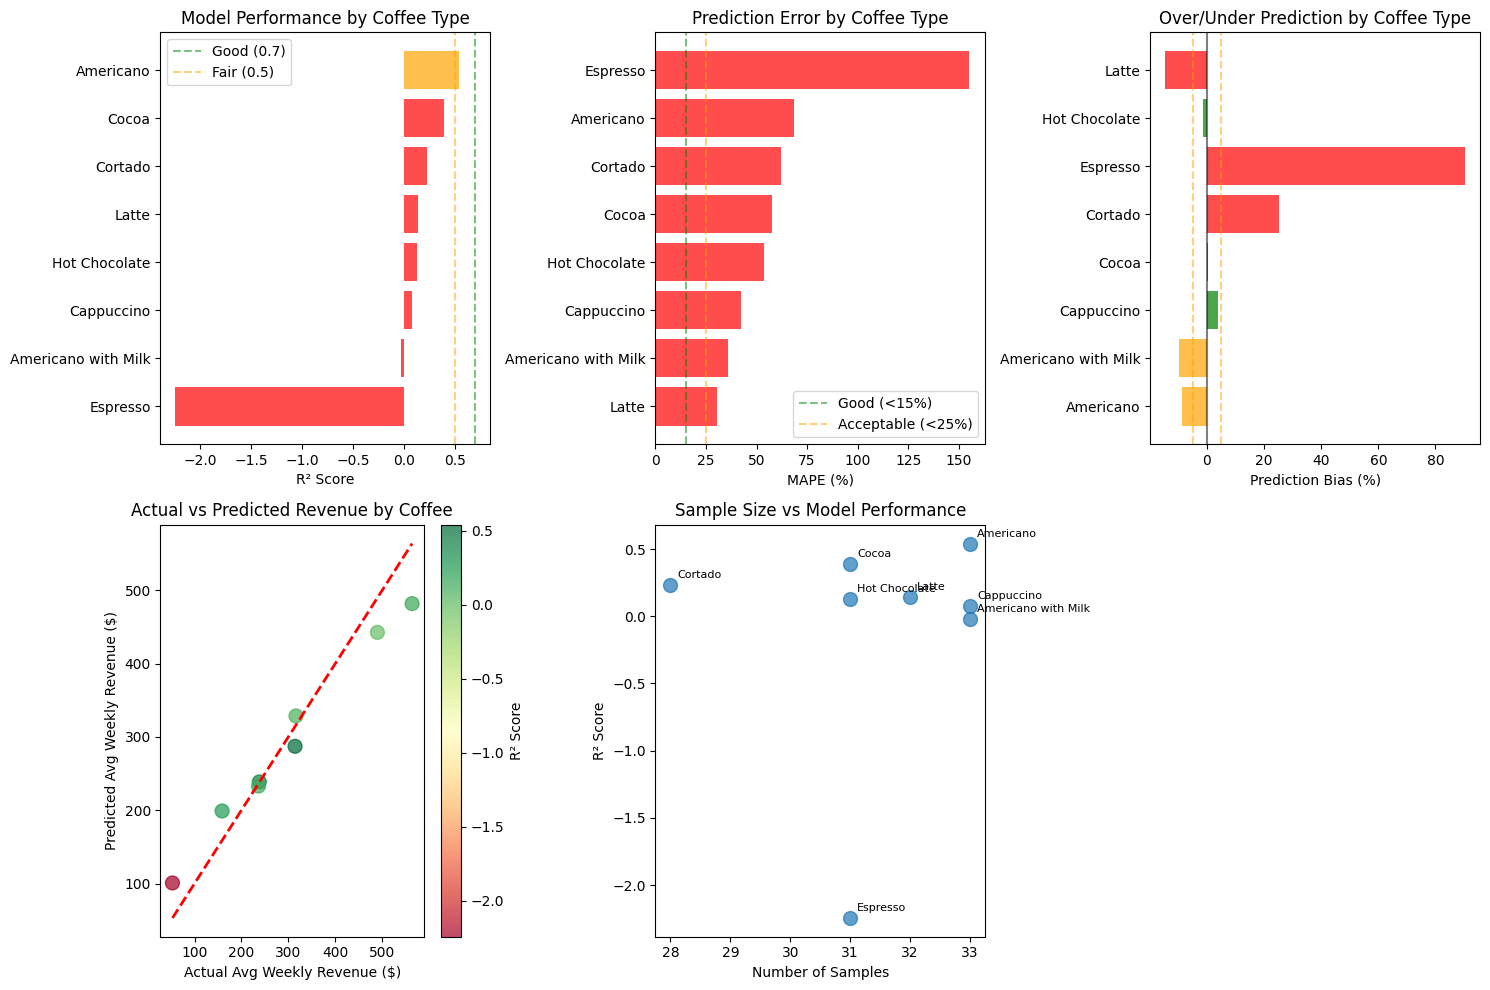

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
coffee_r2_sorted = coffee_performance.sort_values('r2')
colors = ['red' if x < 0.5 else 'orange' if x < 0.7 else 'green' for x in coffee_r2_sorted['r2']]
plt.barh(range(len(coffee_r2_sorted)), coffee_r2_sorted['r2'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_r2_sorted)), coffee_r2_sorted.index)
plt.xlabel('R² Score')
plt.title('Model Performance by Coffee Type')
plt.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (0.5)')
plt.legend()

plt.subplot(2, 3, 2)
coffee_mape_sorted = coffee_performance.sort_values('mape')
colors = ['green' if x < 15 else 'orange' if x < 25 else 'red' for x in coffee_mape_sorted['mape']]
plt.barh(range(len(coffee_mape_sorted)), coffee_mape_sorted['mape'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_mape_sorted)), coffee_mape_sorted.index)
plt.xlabel('MAPE (%)')
plt.title('Prediction Error by Coffee Type')
plt.axvline(x=15, color='green', linestyle='--', alpha=0.5, label='Good (<15%)')
plt.axvline(x=25, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<25%)')
plt.legend()

plt.subplot(2, 3, 3)
colors = ['red' if abs(x) > 10 else 'orange' if abs(x) > 5 else 'green' for x in coffee_performance['prediction_bias']]
plt.barh(range(len(coffee_performance)), coffee_performance['prediction_bias'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_performance)), coffee_performance.index)
plt.xlabel('Prediction Bias (%)')
plt.title('Over/Under Prediction by Coffee Type')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=-5, color='orange', linestyle='--', alpha=0.5)

plt.subplot(2, 3, 4)
plt.scatter(coffee_performance['avg_actual_revenue'], coffee_performance['avg_predicted_revenue'], 
           s=100, alpha=0.7, c=coffee_performance['r2'], cmap='RdYlGn')
plt.plot([coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         [coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         'r--', lw=2)
plt.xlabel('Actual Avg Weekly Revenue ($)')
plt.ylabel('Predicted Avg Weekly Revenue ($)')
plt.title('Actual vs Predicted Revenue by Coffee')
plt.colorbar(label='R² Score')

plt.subplot(2, 3, 5)
plt.scatter(coffee_performance['samples'], coffee_performance['r2'], s=100, alpha=0.7)
for i, coffee in enumerate(coffee_performance.index):
    plt.annotate(coffee, (coffee_performance.loc[coffee, 'samples'], 
                         coffee_performance.loc[coffee, 'r2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Number of Samples')
plt.ylabel('R² Score')
plt.title('Sample Size vs Model Performance')


plt.tight_layout()
plt.show()

### Training: 2024 → predict 2025 weekly revenue

In [14]:
# Load and prepare data
weekly_features = df.copy()
weekly_features['week_start_date'] = pd.to_datetime(weekly_features['week_start_date'])

# Split data
train_end_date = pd.to_datetime('2024-12-31')
test_start_date = pd.to_datetime('2025-01-01')

# Create time-based train/test split
train_mask = weekly_features['week_start_date'] <= train_end_date
test_mask = weekly_features['week_start_date'] >= test_start_date

train_data = weekly_features[train_mask].copy()
test_data = weekly_features[test_mask].copy()

print(f"Training data: {len(train_data)} samples")
print(f"  Date range: {train_data['week_start_date'].min()} to {train_data['week_start_date'].max()}")
print(f"  Coffee types: {train_data['coffee_name'].nunique()}")

print(f"\nTest data: {len(test_data)} samples")
print(f"  Date range: {test_data['week_start_date'].min()} to {test_data['week_start_date'].max()}")
print(f"  Coffee types: {test_data['coffee_name'].nunique()}")

# Remove rows with missing lag features
train_valid_mask = (train_data['prev_week_revenue'] != 0) | (train_data['weekly_revenue'] > 0)
train_clean = train_data[train_valid_mask].copy()

test_valid_mask = (test_data['prev_week_revenue'] != 0) | (test_data['weekly_revenue'] > 0)
test_clean = test_data[test_valid_mask].copy()

# Prepare training data
X_train = train_clean[selected_features]
y_train = train_clean['weekly_revenue']
coffee_train = train_clean['coffee_name']
dates_train = train_clean['week_start_date']

# Prepare test data
X_test = test_clean[selected_features]
y_test = test_clean['weekly_revenue']
coffee_test = test_clean['coffee_name']
dates_test = test_clean['week_start_date']

print(f"\nCleaned training data: {len(X_train)} samples")
print(f"Cleaned test data: {len(X_test)} samples")

Training data: 337 samples
  Date range: 2024-02-26 00:00:00 to 2024-12-30 00:00:00
  Coffee types: 8

Test data: 84 samples
  Date range: 2025-01-06 00:00:00 to 2025-03-17 00:00:00
  Coffee types: 8

Cleaned training data: 337 samples
Cleaned test data: 84 samples


In [15]:
print(f"\n Training model on 80% of data (chronologically)...")
train_data_final = lgb.Dataset(X_train, label=y_train)

final_model = lgb.train(
    lgb_params,
    train_data_final,
    num_boost_round=1000,
    valid_sets=[train_data_final],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(0)]
)

print(f"\n Predicting on holdout 20% (chronologically)...")
predictions_2025 = final_model.predict(X_test)

results_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test,
    'predicted_revenue': predictions_2025,
    'prediction_error': predictions_2025 - y_test,
    'absolute_error': np.abs(predictions_2025 - y_test),
    'percentage_error': ((predictions_2025 - y_test) / y_test) * 100
})

# overall holdout prediction metrics
mae_2025 = mean_absolute_error(y_test, predictions_2025)
rmse_2025 = np.sqrt(mean_squared_error(y_test, predictions_2025))
r2_2025 = r2_score(y_test, predictions_2025)
mape_2025 = np.mean(np.abs((y_test - predictions_2025) / y_test)) * 100

print(f"Holdout Test Performance:")
print(f"  MAE: ${mae_2025:.2f}")
print(f"  RMSE: ${rmse_2025:.2f}")
print(f"  R²: {r2_2025:.3f}")
print(f"  MAPE: {mape_2025:.1f}%")

# Performance by coffee type for combined holdout predictions
coffee_performance_2025 = results_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\nHoldout performance by coffee type")
print(coffee_performance_2025.sort_values('mape_mean'))


 Training model on 80% of data (chronologically)...

 Predicting on holdout 20% (chronologically)...
Holdout Test Performance:
  MAE: $115.30
  RMSE: $171.25
  R²: 0.517
  MAPE: 39.3%

Holdout performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Cappuccino                        11      380.36         305.65   97.37   
Americano with Milk               11      510.59         415.81  151.03   
Latte                             11      484.39         389.00  152.02   
Americano                         11      564.04         391.30  241.82   
Hot Chocolate                     11      224.31         197.80   78.84   
Cocoa                             11      315.34         292.36   89.36   
Espresso                          11       61.27          84.56   27.87   
Cortado                            7      107.55         173.82   66.27   

                     mape_me

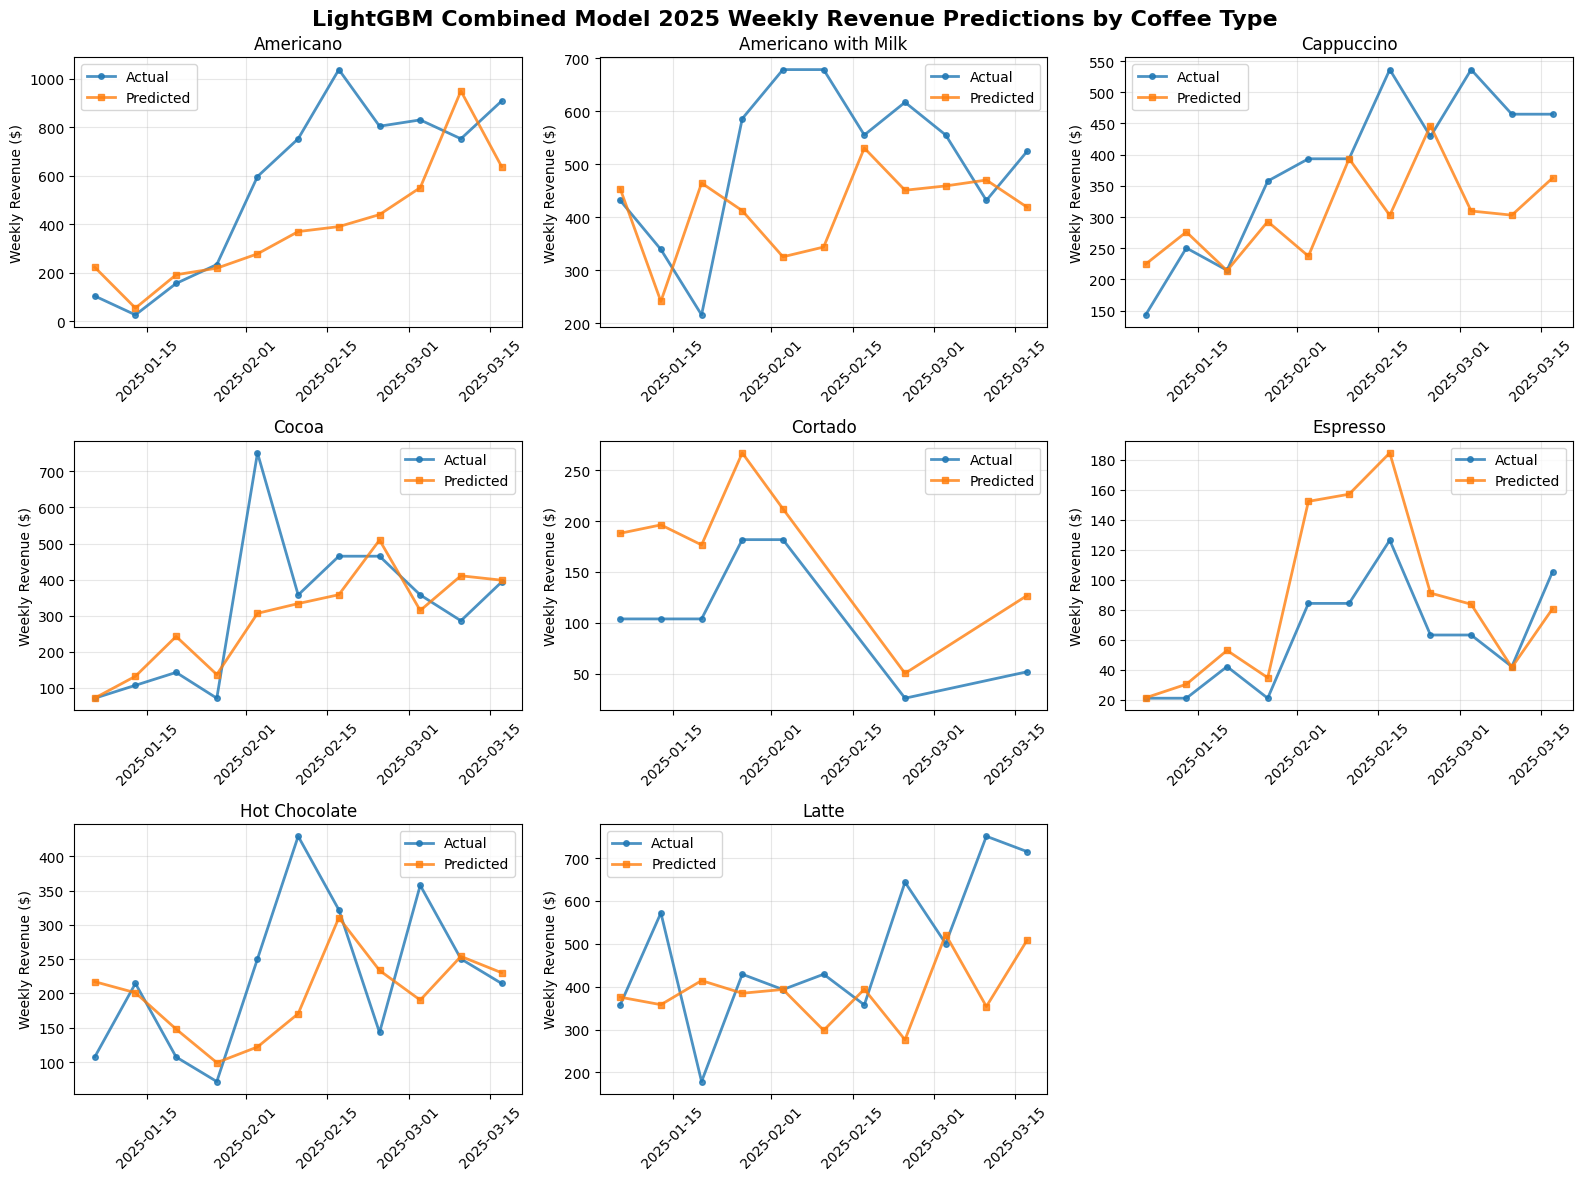

In [16]:
def plot_time_series_predictions(results_df, model_type="Model", figsize=(16, 12)):
    """
    Plot time series predictions for each coffee type.
    
    Parameters:
    results_df: DataFrame with columns ['week_start_date', 'coffee_name', 'actual_revenue', 'predicted_revenue']
    model_type: str, name of the model for the title
    figsize: tuple, figure size
    """
    plt.figure(figsize=figsize)
    
    unique_coffees = results_df['coffee_name'].unique()
    n_coffees = len(unique_coffees)
    cols = 3
    rows = (n_coffees + cols - 1) // cols

    for i, coffee in enumerate(unique_coffees):
        plt.subplot(rows, cols, i + 1)
        
        coffee_data = results_df[results_df['coffee_name'] == coffee].sort_values('week_start_date')
        
        plt.plot(coffee_data['week_start_date'], coffee_data['actual_revenue'], 
                 'o-', label='Actual', linewidth=2, markersize=4, alpha=0.8)
        plt.plot(coffee_data['week_start_date'], coffee_data['predicted_revenue'], 
                 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.8)
        
        plt.title(f'{coffee}')
        plt.ylabel('Weekly Revenue ($)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle(f'{model_type} 2025 Weekly Revenue Predictions by Coffee Type', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot LightGBM results
plot_time_series_predictions(results_2025, "LightGBM Combined Model")

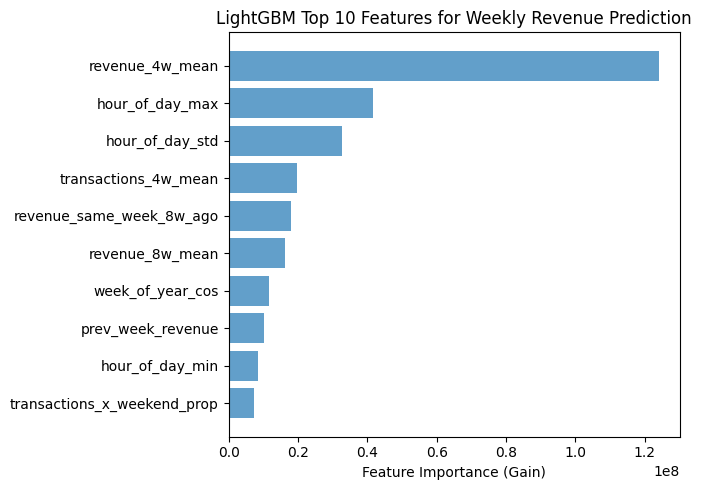

In [17]:
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(7, 5))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('LightGBM Top 10 Features for Weekly Revenue Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Train & Predict Separate LightGBM Models per Coffee Type

In [18]:
unique_coffees = coffee_train.unique()
coffee_models = {}
coffee_results_separate = []

def calculate_smape(y_true, y_pred):
    """Symmetric MAPE: bounded 0-200%, treats over/under predictions equally"""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Simplified parameters for small sample sizes (separate models)
lgb_params_separate = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'gbdt',
    'num_leaves': 15,           # Much smaller - only ~40 samples per coffee
    'learning_rate': 0.05,      # Faster learning
    'feature_fraction': 0.7,    # Strong regularization
    'bagging_fraction': 0.7,    # Strong regularization
    'bagging_freq': 5,
    'min_child_samples': 3,     # Allow small samples but not too small
    'min_child_weight': 1e-3,
    'reg_alpha': 0.5,           # Very strong L1 regularization
    'reg_lambda': 0.5,          # Very strong L2 regularization
    'max_depth': 4,             # Very shallow trees
    'min_split_gain': 0.1,
    'random_state': 42,
    'verbose': -1,
    'force_col_wise': True
}

for coffee in unique_coffees:
    print(f"Training model for {coffee}...")
    
    # Filter training data for coffee
    coffee_mask_train = coffee_train == coffee
    X_train_coffee = X_train[coffee_mask_train]
    y_train_coffee = y_train[coffee_mask_train]
    
    # Filter test data for coffee
    coffee_mask_test = coffee_test == coffee
    X_test_coffee = X_test[coffee_mask_test]
    y_test_coffee = y_test[coffee_mask_test]
    
    # flag if less than 5 training weeks or less than 2 test weeks
    if len(X_train_coffee) < 5 or len(X_test_coffee) < 2:
        print(f"  Insufficient data for {coffee} (train: {len(X_train_coffee)}, test: {len(X_test_coffee)})")
        continue
    
    # Remove coffee_encoded feature since we are training per coffee
    features_no_coffee = [f for f in selected_features if f != 'coffee_encoded']
    X_train_coffee_clean = X_train_coffee[features_no_coffee]
    X_test_coffee_clean = X_test_coffee[features_no_coffee]
    
    # Create validation split (80/20) from training data for early stopping
    n_samples = len(X_train_coffee_clean)
    val_size = max(2, int(n_samples * 0.2))  # At least 2 samples for validation
    train_size = n_samples - val_size
    
    # Use last samples chronologically for validation
    X_train_split = X_train_coffee_clean.iloc[:train_size]
    y_train_split = y_train_coffee.iloc[:train_size]
    X_val_split = X_train_coffee_clean.iloc[train_size:]
    y_val_split = y_train_coffee.iloc[train_size:]
    
    # Train coffee-specific model with validation
    train_data_coffee = lgb.Dataset(X_train_split, label=y_train_split)
    val_data_coffee = lgb.Dataset(X_val_split, label=y_val_split, reference=train_data_coffee)
    
    coffee_model = lgb.train(
        lgb_params_separate,  # Use simplified params
        train_data_coffee,
        num_boost_round=200,  # Reduced from 1000 - prevent overfitting
        valid_sets=[train_data_coffee, val_data_coffee],
        valid_names=['train', 'validation'],
        callbacks=[lgb.early_stopping(20, verbose=False), lgb.log_evaluation(0)]  # Early stopping with 20 rounds
    )
    
    # Make predictions
    pred_coffee = coffee_model.predict(X_test_coffee_clean)
    
    # Calculate metrics including sMAPE
    mae_coffee = mean_absolute_error(y_test_coffee, pred_coffee)
    r2_coffee = r2_score(y_test_coffee, pred_coffee)
    mape_coffee = np.mean(np.abs((y_test_coffee - pred_coffee) / y_test_coffee)) * 100
    smape_coffee = calculate_smape(y_test_coffee.values, pred_coffee)
    
    coffee_results_separate.append({
        'coffee_name': coffee,
        'train_samples': len(X_train_coffee),
        'test_samples': len(X_test_coffee),
        'mae': mae_coffee,
        'r2': r2_coffee,
        'mape': mape_coffee,
        'smape': smape_coffee
    })
    
    coffee_models[coffee] = coffee_model
    print(f"  sMAPE: {smape_coffee:.1f}%, MAPE: {mape_coffee:.1f}%, R²: {r2_coffee:.3f}")

# Results comparison
separate_results_df = pd.DataFrame(coffee_results_separate)
print(f"\n Separate Models Results (sorted by sMAPE)")
print(separate_results_df.sort_values('smape')[['coffee_name', 'smape', 'mape', 'r2', 'train_samples', 'test_samples']])

Training model for Americano...
  sMAPE: 100.9%, MAPE: 119.0%, R²: -1.131
Training model for Americano with Milk...
  sMAPE: 30.8%, MAPE: 31.8%, R²: -0.592
Training model for Cappuccino...
  sMAPE: 43.3%, MAPE: 42.0%, R²: -0.860
Training model for Cocoa...
  sMAPE: 69.3%, MAPE: 66.5%, R²: -0.386
Training model for Cortado...
  sMAPE: 44.3%, MAPE: 69.8%, R²: -0.010
Training model for Espresso...
  sMAPE: 35.5%, MAPE: 41.6%, R²: 0.495
Training model for Hot Chocolate...
  sMAPE: 47.3%, MAPE: 54.2%, R²: -0.151
Training model for Latte...
  sMAPE: 31.0%, MAPE: 38.4%, R²: -0.064

 Separate Models Results (sorted by sMAPE)
           coffee_name       smape        mape        r2  train_samples  \
1  Americano with Milk   30.812437   31.798622 -0.592370             45   
7                Latte   30.960277   38.386800 -0.063993             45   
5             Espresso   35.510818   41.597573  0.495029             38   
2           Cappuccino   43.313466   41.968200 -0.859503             44   


In [19]:
print(f"\n Comparison: Combined Coffee model vs Separate Models")

# Calculate sMAPE for combined model (per coffee)
comparison = coffee_performance_2025[['mape_mean']].copy()
comparison.columns = ['combined_mape']
comparison['combined_smape'] = results_2025.groupby('coffee_name').apply(
    lambda x: calculate_smape(x['actual_revenue'].values, x['predicted_revenue'].values)
)
comparison['combined_r2'] = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

# Calculate sMAPE for separate models
separate_results_df['smape'] = separate_results_df.apply(
    lambda row: calculate_smape(
        y_test[coffee_test == row['coffee_name']].values,
        coffee_models[row['coffee_name']].predict(
            X_test[coffee_test == row['coffee_name']][[f for f in selected_features if f != 'coffee_encoded']]
        )
    ),
    axis=1
)

separate_lookup = separate_results_df.set_index('coffee_name')[['mape', 'smape', 'r2']]
separate_lookup.columns = ['separate_mape', 'separate_smape', 'separate_r2']

comparison = comparison.join(separate_lookup, how='inner')
comparison['mape_improvement'] = comparison['combined_mape'] - comparison['separate_mape']
comparison['smape_improvement'] = comparison['combined_smape'] - comparison['separate_smape']
comparison['r2_improvement'] = comparison['separate_r2'] - comparison['combined_r2']

print(comparison[['combined_smape', 'separate_smape', 'smape_improvement', 'combined_r2', 'separate_r2']].round(2))

print(f"\n=== Primary Metric: Symmetric MAPE (sMAPE) ===")
print(f"Combined Model sMAPE: {comparison['combined_smape'].mean():.1f}%")
print(f"Separate Models sMAPE: {comparison['separate_smape'].mean():.1f}%")
print(f"Improvement: {comparison['smape_improvement'].mean():.1f}% (negative = combined is better)")

print(f"\n=== Secondary Metrics ===")
print(f"Overall MAPE: Combined={coffee_performance_2025['mape_mean'].mean():.1f}% vs Separate={separate_results_df['mape'].mean():.1f}%")
print(f"Overall R² (Averaged by Coffee Type): Combined={comparison['combined_r2'].mean():.3f} vs Separate={comparison['separate_r2'].mean():.3f}")


 Comparison: Combined Coffee model vs Separate Models
                     combined_smape  separate_smape  smape_improvement  \
coffee_name                                                              
Americano                     50.85          100.95             -50.10   
Americano with Milk           33.44           30.81               2.62   
Cappuccino                    27.64           43.31             -15.67   
Cocoa                         28.36           69.31             -40.95   
Cortado                       53.16           44.35               8.82   
Espresso                      32.40           35.51              -3.11   
Hot Chocolate                 37.72           47.29              -9.57   
Latte                         34.25           30.96               3.29   

                     combined_r2  separate_r2  
coffee_name                                    
Americano                   0.24        -1.13  
Americano with Milk        -0.89        -0.59  
Cappuccino  

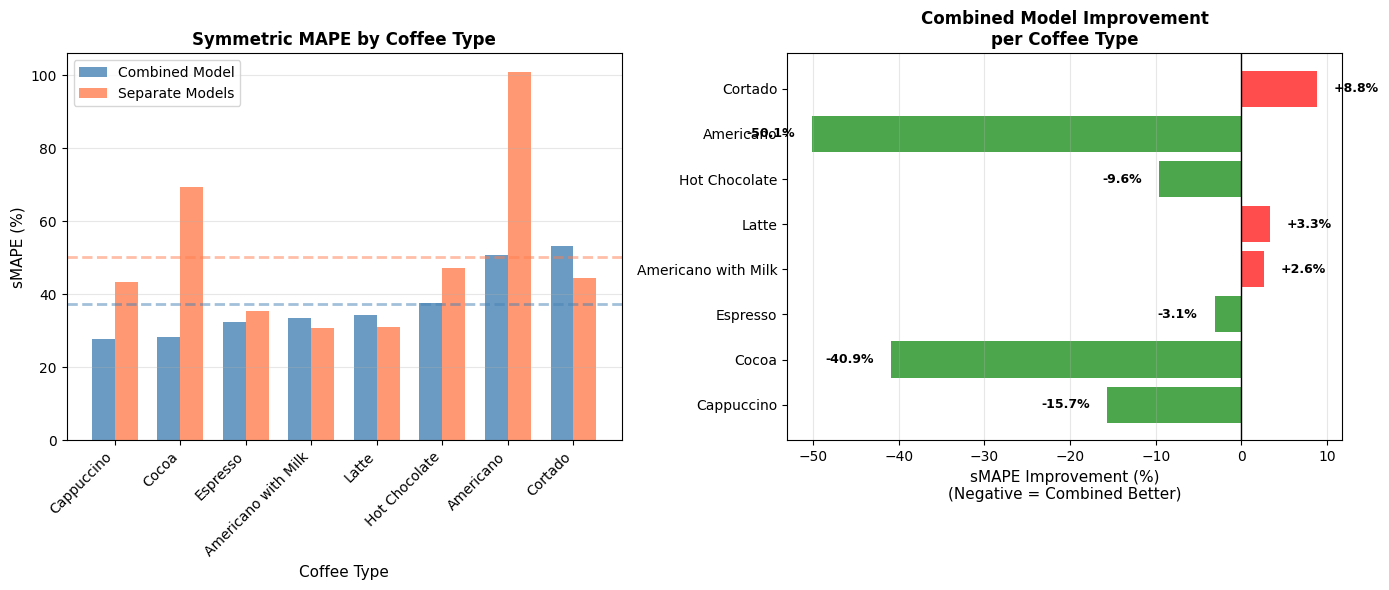

In [21]:
# Visualization: sMAPE Comparison across Coffee Types
plt.figure(figsize=(14, 6))

# Subplot 1: sMAPE Comparison Bar Chart
plt.subplot(1, 2, 1)
coffee_names_sorted = comparison.sort_values('combined_smape').index
x_pos = np.arange(len(coffee_names_sorted))
width = 0.35

combined_smape_sorted = comparison.loc[coffee_names_sorted, 'combined_smape']
separate_smape_sorted = comparison.loc[coffee_names_sorted, 'separate_smape']

plt.bar(x_pos - width/2, combined_smape_sorted, width, label='Combined Model', color='steelblue', alpha=0.8)
plt.bar(x_pos + width/2, separate_smape_sorted, width, label='Separate Models', color='coral', alpha=0.8)

plt.xlabel('Coffee Type', fontsize=11)
plt.ylabel('sMAPE (%)', fontsize=11)
plt.title('Symmetric MAPE by Coffee Type', fontsize=12, fontweight='bold')
plt.xticks(x_pos, coffee_names_sorted, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add average line
avg_combined = comparison['combined_smape'].mean()
avg_separate = comparison['separate_smape'].mean()
plt.axhline(y=avg_combined, color='steelblue', linestyle='--', alpha=0.5, linewidth=2, label=f'Avg Combined: {avg_combined:.1f}%')
plt.axhline(y=avg_separate, color='coral', linestyle='--', alpha=0.5, linewidth=2, label=f'Avg Separate: {avg_separate:.1f}%')

# Subplot 2: Improvement Heatmap
plt.subplot(1, 2, 2)
improvement_sorted = comparison.loc[coffee_names_sorted, 'smape_improvement']
colors = ['green' if x < 0 else 'red' for x in improvement_sorted]

plt.barh(range(len(coffee_names_sorted)), improvement_sorted, color=colors, alpha=0.7)
plt.yticks(range(len(coffee_names_sorted)), coffee_names_sorted)
plt.xlabel('sMAPE Improvement (%)\n(Negative = Combined Better)', fontsize=11)
plt.title('Combined Model Improvement\nper Coffee Type', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')

# Add improvement values
for i, v in enumerate(improvement_sorted):
    if v < 0:
        plt.text(v - 2, i, f'{v:.1f}%', ha='right', va='center', fontsize=9, fontweight='bold')
    else:
        plt.text(v + 2, i, f'+{v:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

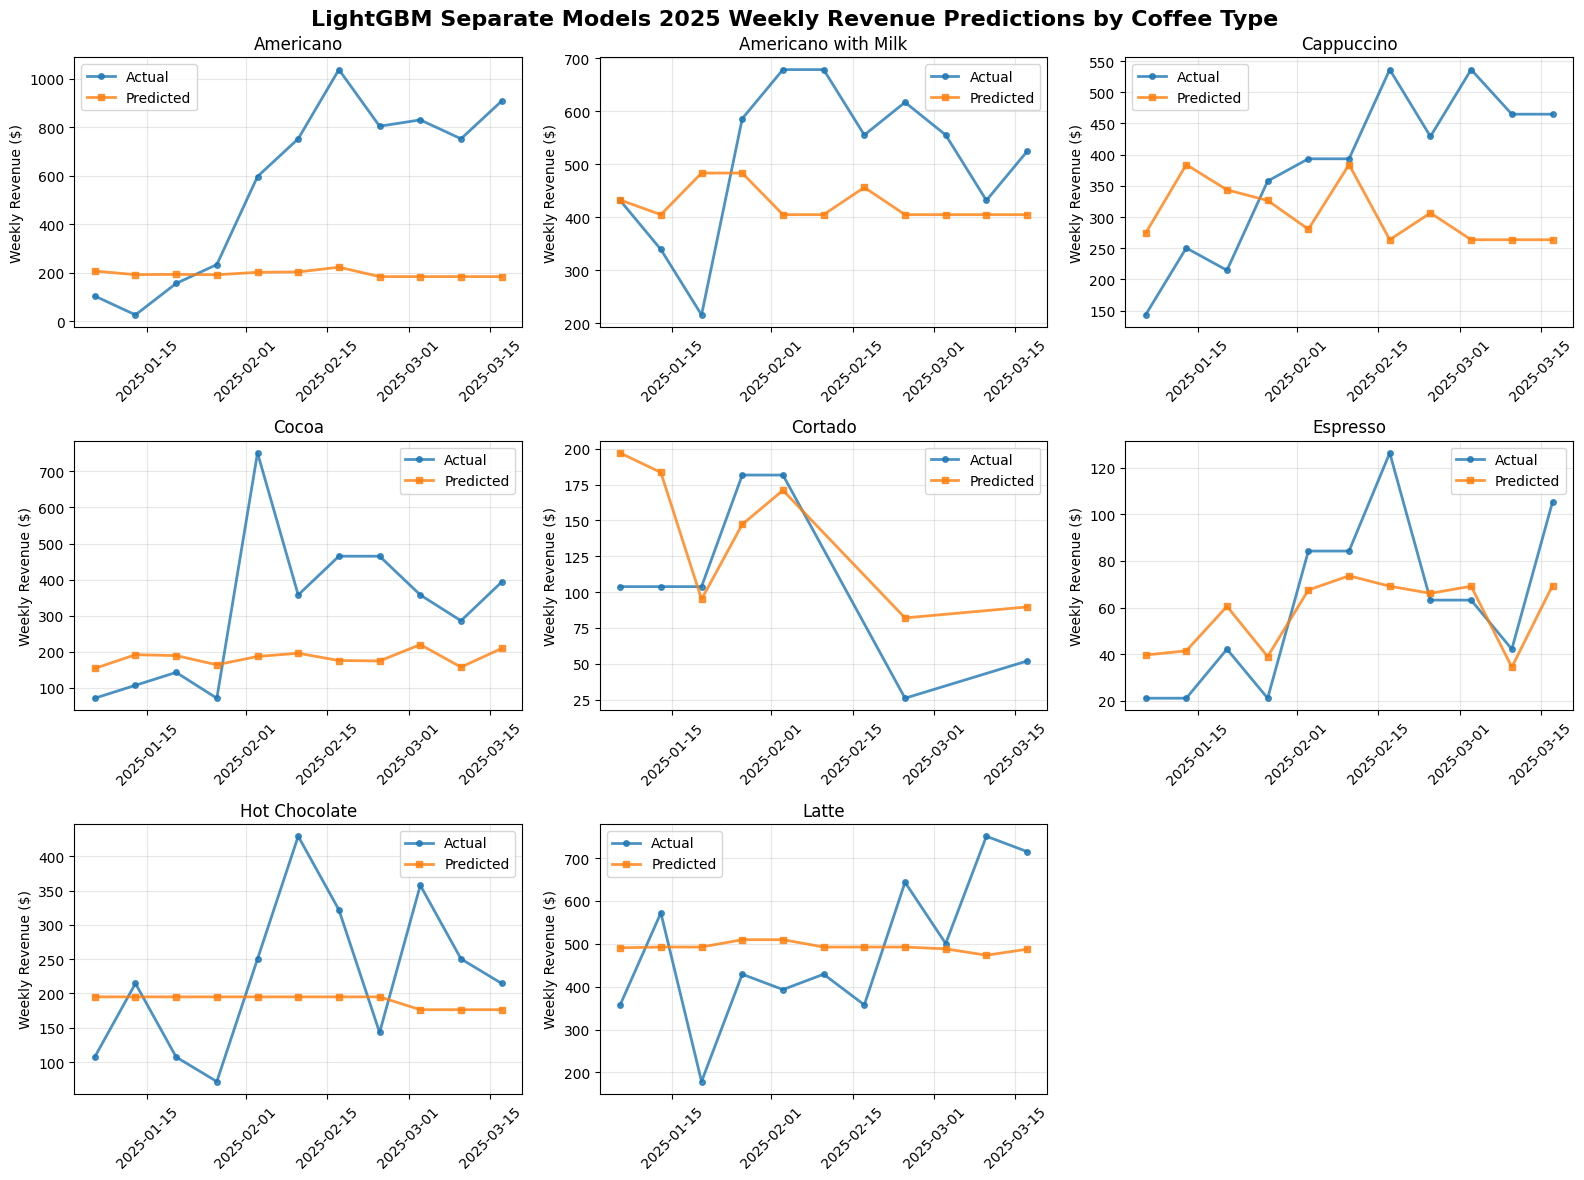

In [22]:
# Plot time series predictions for separate models
# Create DataFrame with separate model predictions
separate_predictions_list = []

for coffee in coffee_models.keys():
    # Get test data for this coffee
    coffee_mask = coffee_test == coffee
    dates_coffee = dates_test[coffee_mask]
    y_actual_coffee = y_test[coffee_mask]
    
    # Get features without coffee_encoded
    features_no_coffee = [f for f in selected_features if f != 'coffee_encoded']
    X_test_coffee = X_test[coffee_mask][features_no_coffee]
    
    # Make predictions
    y_pred_coffee = coffee_models[coffee].predict(X_test_coffee)
    
    # Store results
    for i, (date, actual, pred) in enumerate(zip(dates_coffee, y_actual_coffee, y_pred_coffee)):
        separate_predictions_list.append({
            'week_start_date': date,
            'coffee_name': coffee,
            'actual_revenue': actual,
            'predicted_revenue': pred
        })

results_separate = pd.DataFrame(separate_predictions_list)

# Use the existing plotting function
plot_time_series_predictions(results_separate, "LightGBM Separate Models")


### Combined Model Advantages
- Learns patterns across all coffee types together
- Each model benefits from ~5x more samples
- Captures shared seasonal and temporal patterns
- Diverse coffee patterns prevent overfitting to individual quirks
- More robust predictions due to larger sample size
- All features (including `coffee_encoded`) contribute to learning

### Lasso Regression (Combined Model) and LightGBM Comparison

In [23]:
# Prepare data for Lasso (same train/test split as LightGBM)
X_train_lasso = X_train.copy()
X_test_lasso = X_test.copy()
y_train_lasso = y_train.copy()
y_test_lasso = y_test.copy()

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

# Use LassoCV for automatic alpha selection
print("Finding optimal alpha using cross-validation...")
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 50),  # Test alphas from 0.0001 to 100
    cv=5,                           # 5-fold cross-validation
    random_state=42,
    max_iter=2000                   # Increase iterations for convergence
)

# Fit LassoCV to find best alpha
lasso_cv.fit(X_train_scaled, y_train_lasso)
best_alpha = lasso_cv.alpha_

print(f"Best alpha found: {best_alpha:.6f}")
print(f"Cross-validation R²: {lasso_cv.score(X_train_scaled, y_train_lasso):.3f}")

lasso_temp_coef = lasso_cv.coef_
non_zero_mask = np.abs(lasso_temp_coef) > 0
selected_by_lasso = [selected_features[i] for i in range(len(selected_features)) if non_zero_mask[i]]

print(f"Lasso Features Selected: {len(selected_by_lasso)} out of {len(selected_features)}")

Finding optimal alpha using cross-validation...
Best alpha found: 2.559548
Cross-validation R²: 0.716
Lasso Features Selected: 11 out of 25


In [24]:
eliminated_features = [selected_features[i] for i in range(len(selected_features)) if not non_zero_mask[i]]
if eliminated_features:
    print(f"\nFeatures eliminated by Lasso ({len(eliminated_features)}):")
    for feature in eliminated_features:
        print(f"  ✗ {feature}")


Features eliminated by Lasso (14):
  ✗ prev_week_transactions
  ✗ prev_3week_revenue
  ✗ prev_2week_transactions
  ✗ prev_3week_transactions
  ✗ week_of_year_cos
  ✗ transactions_4w_mean
  ✗ revenue_12w_mean
  ✗ transactions_8w_mean
  ✗ transactions_12w_mean
  ✗ revenue_same_week_4w_ago
  ✗ revenue_same_week_8w_ago
  ✗ prev_revenue_x_month
  ✗ prev_revenue_x_week_of_year
  ✗ transactions_x_weekend_prop


In [25]:
# Train final Lasso model with best alpha
lasso_final = Lasso(alpha=best_alpha, random_state=12, max_iter=2000)
lasso_final.fit(X_train_scaled, y_train_lasso)

# Make predictions on 2025 test data
predictions_lasso_2025 = lasso_final.predict(X_test_scaled)

# Calculate Lasso performance metrics
mae_lasso_2025 = mean_absolute_error(y_test_lasso, predictions_lasso_2025)
rmse_lasso_2025 = np.sqrt(mean_squared_error(y_test_lasso, predictions_lasso_2025))
r2_lasso_2025 = r2_score(y_test_lasso, predictions_lasso_2025)
mape_lasso_2025 = np.mean(np.abs((y_test_lasso - predictions_lasso_2025) / y_test_lasso)) * 100

print(f"\n Lasso Regression -  2025 Performance")
print(f"MAE: ${mae_lasso_2025:.2f}")
print(f"RMSE: ${rmse_lasso_2025:.2f}")
print(f"R²: {r2_lasso_2025:.3f}")
print(f"MAPE: {mape_lasso_2025:.1f}%")


 Lasso Regression -  2025 Performance
MAE: $86.68
RMSE: $126.78
R²: 0.735
MAPE: 31.2%


In [26]:
results_lasso_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test_lasso,
    'predicted_revenue': predictions_lasso_2025,
    'prediction_error': predictions_lasso_2025 - y_test_lasso,
    'absolute_error': np.abs(predictions_lasso_2025 - y_test_lasso),
    'percentage_error': ((predictions_lasso_2025 - y_test_lasso) / y_test_lasso) * 100
})

coffee_performance_lasso_2025 = results_lasso_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_lasso_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\n Lasso 2025 performance by coffee type")
print(coffee_performance_lasso_2025.sort_values('mape_mean'))


 Lasso 2025 performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Hot Chocolate                     11      224.31         185.05   70.66   
Americano with Milk               11      510.59         440.43   93.78   
Cocoa                             11      315.34         277.27   91.38   
Latte                             11      484.39         424.30  105.46   
Americano                         11      564.04         416.89  185.04   
Cappuccino                        11      380.36         375.00   55.59   
Espresso                          11       61.27          72.80   24.51   
Cortado                            7      107.55         160.58   55.72   

                     mape_mean  mape_std  
coffee_name                               
Hot Chocolate            -9.79     42.05  
Americano with Milk      -8.39     24.45  
Cocoa                    -7.34     37

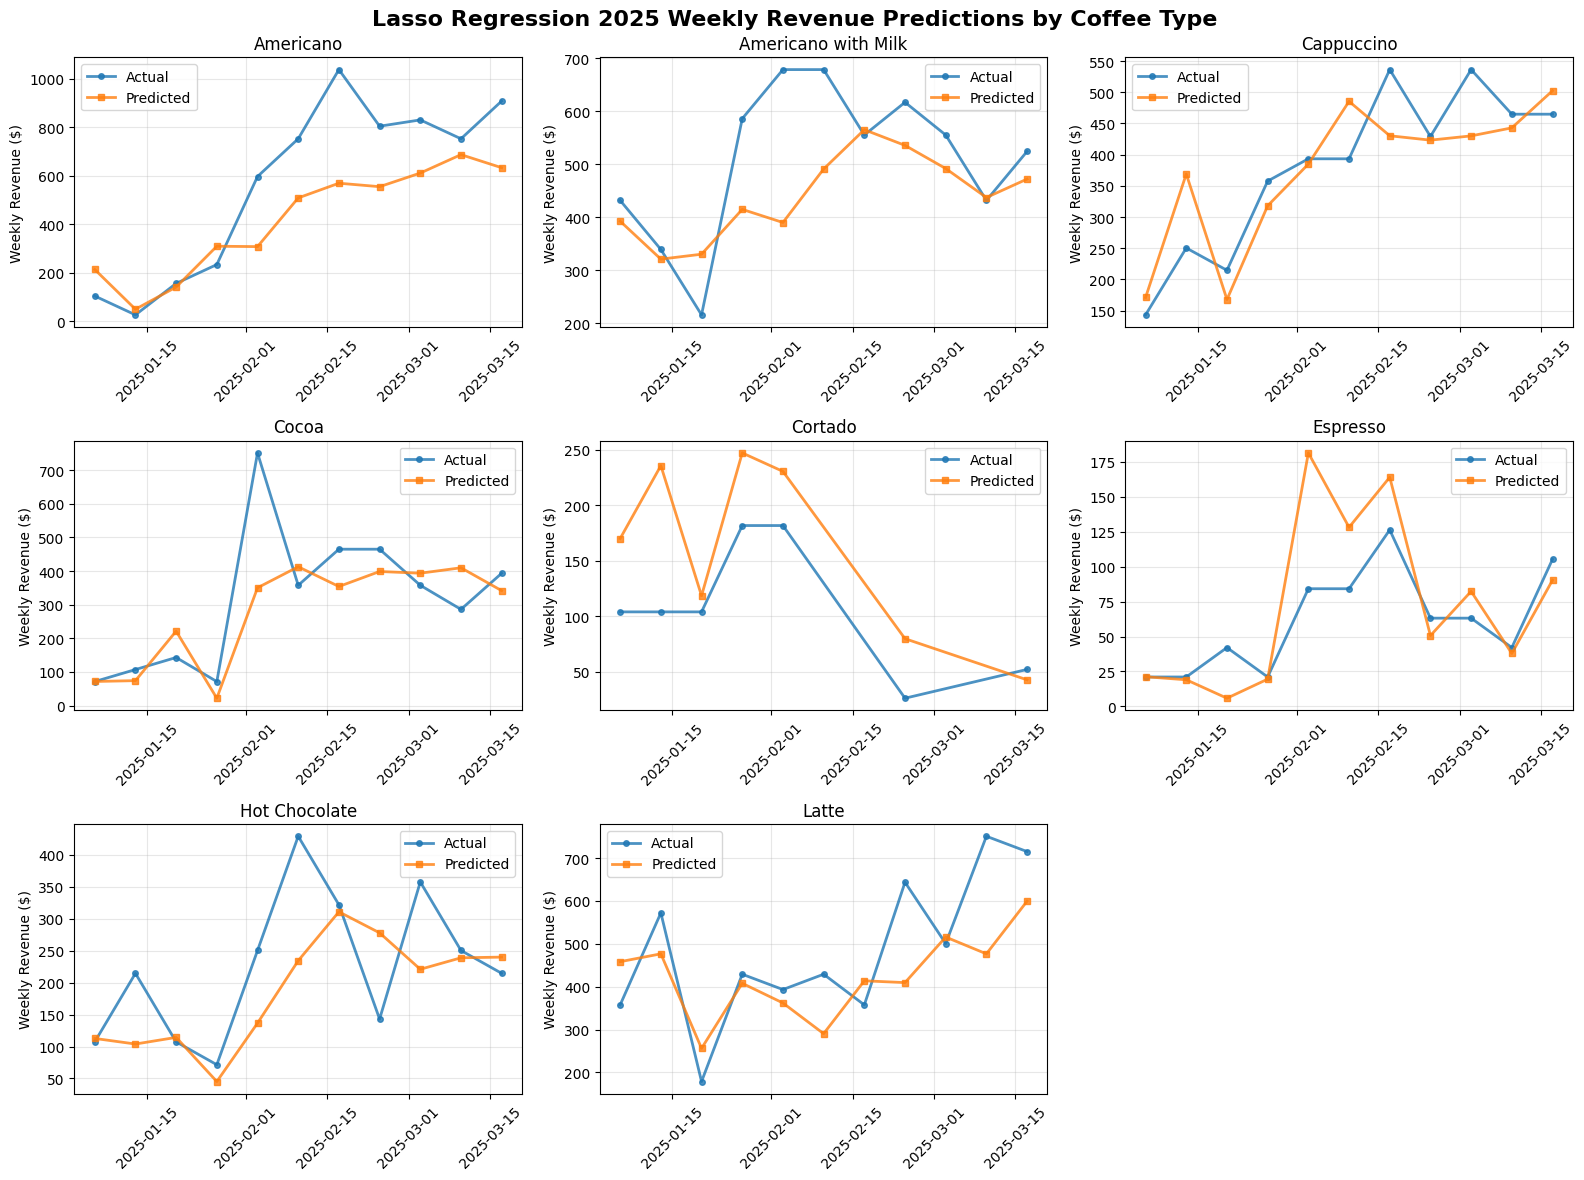

In [27]:
plot_time_series_predictions(results_lasso_2025, "Lasso Regression")

In [29]:
# Calculate average R² per coffee type for fair comparison
lasso_r2_by_coffee = results_lasso_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)
lasso_avg_r2 = lasso_r2_by_coffee.mean()

# Calculate sMAPE for Lasso (overall and per coffee)
smape_lasso_2025 = calculate_smape(y_test_lasso.values, predictions_lasso_2025)

lasso_smape_by_coffee = results_lasso_2025.groupby('coffee_name').apply(
    lambda x: calculate_smape(x['actual_revenue'].values, x['predicted_revenue'].values)
)
lasso_avg_smape = lasso_smape_by_coffee.mean()

# Calculate overall sMAPE for LightGBM
smape_lgb_2025 = calculate_smape(y_test.values, predictions_2025)

print(f"LightGBM vs Lasso Regression (2025 predictions)")
print(f"")
print(f"=== PRIMARY METRIC: Symmetric MAPE (sMAPE) ===")
print(f"  LightGBM sMAPE: {smape_lgb_2025:.1f}% | Lasso sMAPE: {smape_lasso_2025:.1f}%")
print(f"")
print(f"Overall Performance:")
print(f"  LightGBM R²: {r2_2025:.3f} | Lasso R²: {r2_lasso_2025:.3f}")
print(f"  LightGBM MAPE: {mape_2025:.1f}% | Lasso MAPE: {mape_lasso_2025:.1f}%")
print(f"")
print(f"Average sMAPE per Coffee Type:")
print(f"  LightGBM: {comparison['combined_smape'].mean():.1f}%")
print(f"  Lasso: {lasso_avg_smape:.1f}%")
print(f"")
print(f"Average R² per Coffee Type:")
print(f"  LightGBM: {comparison['combined_r2'].mean():.3f}")
print(f"  Lasso: {lasso_avg_r2:.3f}")
print(f"")
print(f"Average MAPE per Coffee Type:")
print(f"  LightGBM: {coffee_performance_2025['mape_mean'].mean():.1f}%")
print(f"  Lasso: {coffee_performance_lasso_2025['mape_mean'].mean():.1f}%")

LightGBM vs Lasso Regression (2025 predictions)

=== PRIMARY METRIC: Symmetric MAPE (sMAPE) ===
  LightGBM sMAPE: 36.5% | Lasso sMAPE: 30.2%

Overall Performance:
  LightGBM R²: 0.517 | Lasso R²: 0.735
  LightGBM MAPE: 39.3% | Lasso MAPE: 31.2%

Average sMAPE per Coffee Type:
  LightGBM: 37.2%
  Lasso: 30.8%

Average R² per Coffee Type:
  LightGBM: -0.221
  Lasso: 0.225

Average MAPE per Coffee Type:
  LightGBM: 13.3%
  Lasso: 5.3%


In [ ]:
# Feature importance for Lasso (non-zero coefficients)
lasso_coefficients = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lasso_final.coef_,
    'abs_coefficient': np.abs(lasso_final.coef_)
})

# features that weren't zeroed out by Lasso
non_zero_features = lasso_coefficients[lasso_coefficients['abs_coefficient'] > 0].sort_values('abs_coefficient', ascending=False)

print(f"Features selected by Lasso: {len(non_zero_features)} out of {len(selected_features)}")
print(f"\nTop 15 most important features (by absolute coefficient):")
print(non_zero_features.head(15)[['feature', 'coefficient']])

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
models = ['LightGBM', 'Lasso']
r2_scores = [r2_2025, r2_lasso_2025]
colors = ['lightblue', 'lightcoral']
bars = plt.bar(models, r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Overall R² Comparison (2025)')
plt.ylim(0, 1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.subplot(2, 3, 2)
mape_scores = [mape_2025, mape_lasso_2025]
bars = plt.bar(models, mape_scores, color=colors, alpha=0.7)
plt.ylabel('MAPE (%)')
plt.title('Overall MAPE Comparison (2025)')
for i, v in enumerate(mape_scores):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.subplot(2, 3, 3)
lgb_r2_by_coffee = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

coffee_names = lgb_r2_by_coffee.index
x_pos = np.arange(len(coffee_names))
width = 0.35

plt.bar(x_pos - width/2, lgb_r2_by_coffee.values, width, label='LightGBM', color='lightblue', alpha=0.7)
plt.bar(x_pos + width/2, lasso_r2_by_coffee.values, width, label='Lasso', color='lightcoral', alpha=0.7)

plt.xlabel('Coffee Type')
plt.ylabel('R² Score')
plt.title('R² by Coffee Type')
plt.xticks(x_pos, coffee_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
top_lgb_features = feature_importance.head(10)
top_lasso_features = non_zero_features.head(10)

plt.barh(range(len(top_lgb_features)), top_lgb_features['importance'], alpha=0.7, label='LightGBM')
plt.yticks(range(len(top_lgb_features)), top_lgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 LightGBM Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 5)
plt.barh(range(len(top_lasso_features)), top_lasso_features['abs_coefficient'], alpha=0.7, color='lightcoral')
plt.yticks(range(len(top_lasso_features)), top_lasso_features['feature'])
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Lasso Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 6)
plt.scatter(y_test_lasso, predictions_2025, alpha=0.6, label='LightGBM', s=30)
plt.scatter(y_test_lasso, predictions_lasso_2025, alpha=0.6, label='Lasso', s=30)
plt.plot([y_test_lasso.min(), y_test_lasso.max()], [y_test_lasso.min(), y_test_lasso.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted (2025)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparison Summary
* Lasso performs better overall (R²: 0.735 vs 0.517)
* Lasso has a better overall MAPE (31.2% vs. 39.3%)
* Lasso selected 11 features out of 25
* LightGBM uses complex tree interactions, Lasso uses linear relationships